In [2]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIR import *
import scipy as sp

In [60]:
N2O_EDGAR_HYDE = pd.read_csv('./Conc_fit_data/edgar_hyde1.4-glob_n2o.csv',index_col=0,names=['Year','N2O'],skiprows=1)
N2O_EDGAR_v432 = pd.read_csv('./Conc_fit_data/v432_N2O_1970_2012.csv',index_col=0,names=['Year','N2O'],skiprows=1)

CH4_CEDS = pd.read_csv('./Conc_fit_data/CEDS_CH4_global_emissions_1850_2014.csv',index_col=0,names=['Year','CH4'],skiprows=0).drop_duplicates()
CH4_EDGAR_HYDE = pd.read_csv('./Conc_fit_data/edgar_hyde1.4-glob_CH4.csv',index_col=0)
CH4_EDGAR_v432 = pd.read_csv('./Conc_fit_data/v432_CH4_1970_2012.csv',index_col=0)

CO2_CEDS = pd.read_csv('./Conc_fit_data/CEDS_CO2_global_emissions_1750_2014.csv',index_col=0,names=['Year','CO2'])*(12/44)
GCP = pd.read_csv('./Conc_fit_data/Global_Carbon_Budget_2018v1.0.csv',index_col=0)
CO2_GCP = GCP.fillna(0).sum(axis=1)
CO2_GCP = pd.DataFrame(data= CO2_GCP.values, index = CO2_GCP.index,columns=['CO2'])
CO2_EDGAR_HYDE = pd.read_csv('./Conc_fit_data/edgar_hyde1.4-glob_CO2.csv',index_col=0)
CO2_EDGAR_v432_Fossil = pd.read_csv('./Conc_fit_data/v432_CO2_excl_short-cycle_org_C_1970_2012.csv',index_col=0)
CO2_EDGAR_v432_Bio = pd.read_csv('./Conc_fit_data/v432_CO2_org_short-cycle_C_1970_2012.csv',index_col=0)
CO2_EDGAR_v432 = pd.DataFrame(data=CO2_EDGAR_v432_Fossil.values+CO2_EDGAR_v432_Bio.values,columns=['CO2'],index=CO2_EDGAR_v432_Bio.index)

RCP85_E = pd.read_csv('./RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP_ems = pd.DataFrame(data = np.array([RCP85_E[['OtherCO2','FossilCO2']].sum(axis=1).values,RCP85_E['CH4'].values,RCP85_E['N2O'].values]).T,columns=['CO2','CH4','N2O'],index = RCP85_E.index)


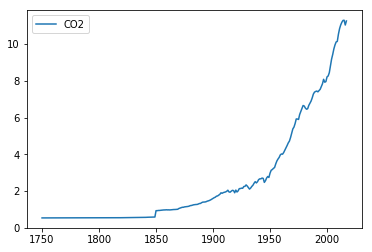

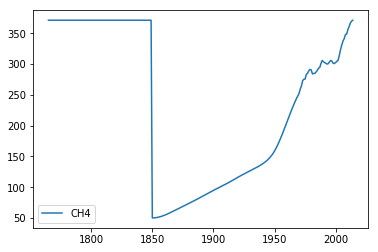

In [55]:
## Trying a slightly different method of harmonizing the emissions:

CO2_index = CO2_GCP.index
CO2_CEDS = CO2_CEDS.reindex(CO2_index)
CO2_EDGAR_HYDE = CO2_EDGAR_HYDE.reindex(CO2_index)
CO2_EDGAR_v432 = CO2_EDGAR_v432.reindex(CO2_index)

CO2_all = pd.concat([CO2_GCP,CO2_CEDS,CO2_EDGAR_HYDE,CO2_EDGAR_v432],axis=1)

CO2_test = pd.DataFrame((CO2_GCP.loc[2017].values - np.roll(np.cumsum(CO2_all.diff().mean(axis=1).values[::-1]),1))[::-1],columns=['CO2'],index=np.arange(1750,2018)).fillna(CO2_GCP.loc[2017])

CO2_test.plot()

CH4_index = np.arange(1765,2015)
CH4_CEDS = CH4_CEDS.reindex(CH4_index)
CH4_EDGAR_HYDE = CH4_EDGAR_HYDE.reindex(CH4_index)
CH4_EDGAR_v432 = CH4_EDGAR_v432.reindex(CH4_index)

CH4_all = pd.concat([CH4_CEDS,CH4_EDGAR_HYDE,CH4_EDGAR_v432],axis=1)

CH4_test = pd.DataFrame((CH4_CEDS.loc[2014].values - np.roll(np.cumsum(CH4_all.diff().mean(axis=1).values[::-1]),1))[::-1],columns=['CH4'],index=np.arange(1765,2015)).fillna(CH4_CEDS.loc[2014])

CH4_test.plot()

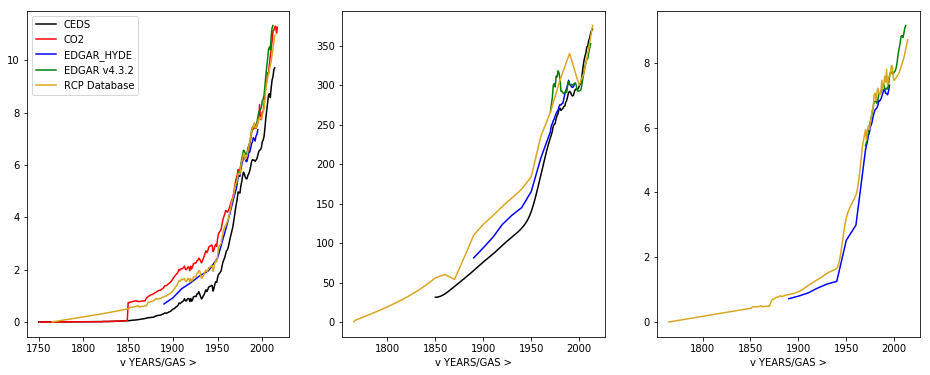

In [61]:
fig,ax = plt.subplots(1,3,figsize=(16,6))

CO2_CEDS.CO2.plot(ax=ax[0],color='k',label='CEDS')
CO2_GCP.plot(ax=ax[0],color='r',label='GCP')
CO2_EDGAR_HYDE.CO2.plot(ax=ax[0],color='b',label='EDGAR_HYDE')
CO2_EDGAR_v432.CO2.plot(ax=ax[0],color='g',label='EDGAR v4.3.2')
RCP_ems.CO2.loc[:2014].plot(ax=ax[0],color='goldenrod',label='RCP Database')

ax[0].legend()

CH4_CEDS.CH4.plot(ax=ax[1],color='k')
CH4_EDGAR_HYDE.CH4.plot(ax=ax[1],color='b')
CH4_EDGAR_v432.CH4.plot(ax=ax[1],color='g')
RCP_ems.CH4.loc[:2014].plot(ax=ax[1],color='goldenrod')

N2O_EDGAR_HYDE.iloc[:,0].plot(ax=ax[2],color='b')
N2O_EDGAR_v432.iloc[:,0].plot(ax=ax[2],color='g')
RCP_ems.N2O.loc[:2014].plot(ax=ax[2],color='goldenrod')

In [62]:
## CH4 : join CEDS and EDGARv432 together in 1970, scaling CEDS upwards to fit
CH4_1850_2012 = (CH4_CEDS * CH4_EDGAR_v432.loc[1970] / CH4_CEDS.loc[1970]).loc[:1969].append(CH4_EDGAR_v432)
# Now join scaled RCP to the start
CH4_1765_2012 = (RCP_ems.loc[1765:1849,'CH4']*CH4_1850_2012.loc[1850,'CH4']/RCP_ems.loc[1850,'CH4']).append(CH4_1850_2012.CH4)

## N2O : join the EDGAR datasets together in 1970:
N2O_1890_2012 = (N2O_EDGAR_HYDE * N2O_EDGAR_v432.loc[1970] / N2O_EDGAR_HYDE.loc[1970]).loc[:1969].append(N2O_EDGAR_v432)
# Now join scaled RCP to the start:
N2O_1765_2012 = (RCP_ems.loc[1765:1889,'N2O']*N2O_1890_2012.loc[1890,'N2O']/RCP_ems.loc[1890,'N2O']).append(N2O_1890_2012.N2O)
# Now scale to match Prather in present day:
N2O_1765_2012 = N2O_1765_2012 * 6.6 / N2O_1765_2012.loc[2010]

## CO2 : join RCP to GCP in 1850
CO2_1765_2012 = (RCP_ems.loc[1765:1849,'CO2']*CO2_GCP.loc[1850,'CO2']/RCP_ems.loc[1850,'CO2']).append(CO2_GCP.loc[1850:2012,'CO2'])

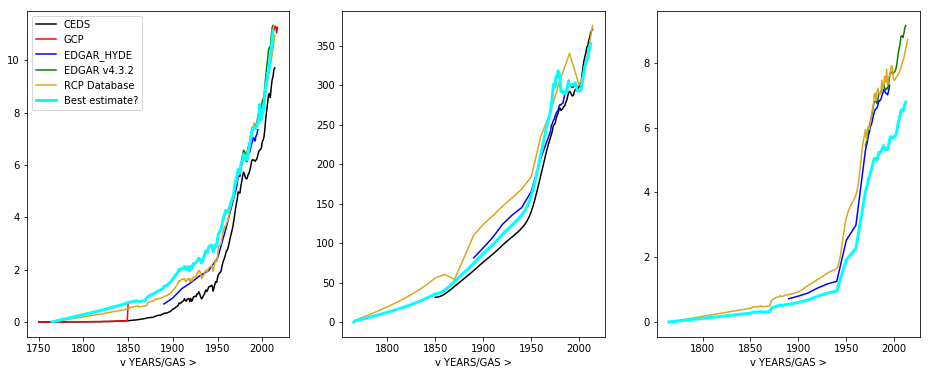

In [63]:
# Now replot with the new harmonized series:
fig,ax = plt.subplots(1,3,figsize=(16,6))

CO2_CEDS.CO2.plot(ax=ax[0],color='k',label='CEDS')
CO2_GCP.CO2.plot(ax=ax[0],color='r',label='GCP')
CO2_EDGAR_HYDE.CO2.plot(ax=ax[0],color='b',label='EDGAR_HYDE')
CO2_EDGAR_v432.CO2.plot(ax=ax[0],color='g',label='EDGAR v4.3.2')
RCP_ems.CO2.loc[:2014].plot(ax=ax[0],color='goldenrod',label='RCP Database')
CO2_1765_2012.plot(ax=ax[0],color='cyan',linewidth=3,label='Best estimate?')

ax[0].legend()

CH4_CEDS.CH4.plot(ax=ax[1],color='k')
CH4_EDGAR_HYDE.CH4.plot(ax=ax[1],color='b')
CH4_EDGAR_v432.CH4.plot(ax=ax[1],color='g')
RCP_ems.CH4.loc[:2014].plot(ax=ax[1],color='goldenrod')
CH4_1765_2012.plot(ax=ax[1],color='cyan',linewidth=3)

N2O_EDGAR_HYDE.iloc[:,0].plot(ax=ax[2],color='b')
N2O_EDGAR_v432.iloc[:,0].plot(ax=ax[2],color='g')
RCP_ems.N2O.loc[:2014].plot(ax=ax[2],color='goldenrod')
N2O_1765_2012.plot(ax=ax[2],color='cyan',linewidth=3)

In [64]:
emissions = pd.DataFrame(data=[CO2_1765_2012.reindex(np.arange(1765,2013)).interpolate(kind='cubic'),CH4_1765_2012.reindex(np.arange(1765,2013)).interpolate(kind='cubic'),N2O_1765_2012.reindex(np.arange(1765,2013)).interpolate(kind='cubic')],index=['CO2','CH4','N2O']).transpose()
#emissions.to_csv('Best_estimate_emissions_for_UnFaIR.csv')

In [81]:
CO2_test['CO2'].loc[1765:1849] = RCP_ems['CO2'].loc[:1849] * CO2_test.loc[1850].values / RCP_ems['CO2'].loc[1850]

CH4_test['CH4'].loc[1765:1849] = RCP_ems['CH4'].loc[:1849] * CH4_test.loc[1850].values / RCP_ems['CH4'].loc[1850]

emissions_test = pd.DataFrame(data=[CO2_test.reindex(np.arange(1765,2013)).values.flatten(),CH4_test.reindex(np.arange(1765,2013)).values.flatten(),N2O_1765_2012.reindex(np.arange(1765,2013)).interpolate(kind='cubic')],index=['CO2','CH4','N2O'],columns=np.arange(1765,2013)).transpose()

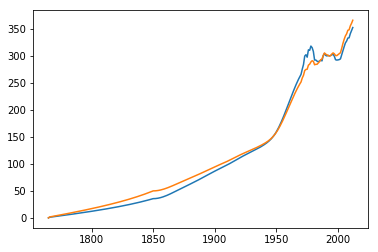

In [82]:
emissions.CH4.plot()
emissions_test.CH4.plot()

In [87]:
# s='85'

# RCP_forc = pd.read_csv('./Conc_fit_data/RCP'+s+'_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

# otherforc = RCP_forc.TOTAL_INCLVOLCANIC_RF.loc[:2012].values - RCP_forc.CO2CH4N2O_RF.loc[:2012].values

# CMIP6_concs = pd.read_csv('./CMIP_input_ems/Supplementary_Table_UoM_GHGConcentrations-1-1-0_annualmeans_v23March2017.csv',skiprows=21,index_col=0)

# CMIP6_concs.CH4.loc[1850:].plot(color='k')

# UnFaIR(emissions_test,otherforc)['C']['CH4'].plot()
# UnFaIR(emissions,otherforc)['C']['CH4'].plot()